In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [165]:
# read telescope_data

telescope_data = pd.read_csv("datasets/telescope_data.csv", index_col=0)
telescope_data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [166]:
# data rebalancing
class_col = "class"
gamma = telescope_data[telescope_data[class_col] == 'g']
hadron_rows = telescope_data[class_col].value_counts()[0] # number of hadron samples
gamma_rows = telescope_data[class_col].value_counts()[1]  # number of gamma samples 

telescope_data = telescope_data.sample(frac=1).reset_index(drop=True)
telescope_data = telescope_data.drop(telescope_data[telescope_data[class_col].eq('g')].sample(hadron_rows - gamma_rows).index)
telescope_data

/tmp/ipykernel_27664/715706781.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hadron_rows = telescope_data[class_col].value_counts()[0] # number of hadron samples
/tmp/ipykernel_27664/715706781.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma_rows = telescope_data[class_col].value_counts()[1]  # number of gamma samples


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,52.6356,26.6227,2.9641,0.1990,0.1106,-25.7710,-18.9617,-6.4777,34.3564,167.1355,h
2,23.4563,11.3381,2.5051,0.5188,0.2766,7.9259,6.9172,5.2721,21.8170,141.4620,g
4,13.0748,10.8737,2.1123,0.7645,0.4517,-14.0346,4.7986,10.6327,16.2580,197.1800,g
5,21.3385,10.4966,2.2529,0.5531,0.3045,-5.8033,17.4759,9.7582,17.1321,55.6086,g
6,80.2375,9.5778,2.7759,0.3178,0.1797,7.9203,43.2221,1.9162,27.1433,301.8484,h
...,...,...,...,...,...,...,...,...,...,...,...
19009,73.2223,22.4882,2.8659,0.4095,0.2621,-59.0820,50.2243,14.8263,0.1012,286.3199,h
19013,30.2753,6.5382,2.7286,0.6516,0.3564,-6.4232,15.8474,-6.1027,7.9518,199.3748,h
19015,23.4810,20.2189,2.5617,0.4856,0.3306,12.2016,10.8270,16.7935,71.6030,134.7350,g
19017,85.3100,58.4564,3.7029,0.1788,0.1063,-95.0866,-50.3138,33.7908,44.2953,280.9660,h


In [167]:
#splitting data

total_rows = telescope_data.shape[0]

training_set_ratio = 0.7
validation_set_ratio = 0.15
test_set_ratio = 0.15

training_end = int(total_rows * training_set_ratio)
validation_end = int(total_rows * (training_set_ratio + validation_set_ratio))

training_set = telescope_data[:training_end]
validation_set = telescope_data[training_end:validation_end]
test_set = telescope_data[validation_end:]


In [176]:
# KNN Classifier Manually

from collections import Counter

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.to_numpy()
        self.y_train = y.to_numpy()

    def predict(self, X):
        X = X.to_numpy()
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _predict(self, x):
        # compute the distance
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]

        # get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # majority vote
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

classifier = KNN(k=7)
classifier.fit(training_set.iloc[:, :-1], training_set[class_col])
predictions = classifier.predict(validation_set.iloc[:, :-1])

print(predictions)

['h' 'g' 'g' ... 'g' 'h' 'h']


Accuracy: 78.22%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.744570  0.857000  0.796839
1     h   0.832749  0.707753  0.765180

Confusion Matrix:


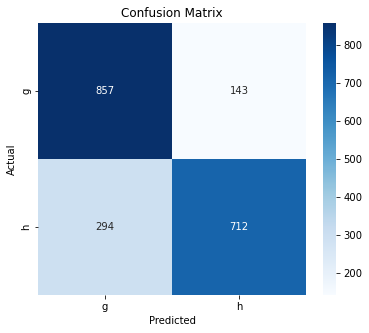

In [ ]:
# classification evaluation manually before standardization

def evaluate_classification(y_target, y_predicted):
    
    y_target = np.array(y_target)
    y_predicted = np.array(y_predicted)

    # get classes
    classes = np.unique(np.concatenate((y_target, y_predicted)))

    # initialize confusion_matrix
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    # fill confusion_matrix
    for i in range(len(y_target)):
        true_idx = np.where(classes == y_target[i])[0][0]
        pred_idx = np.where(classes == y_predicted[i])[0][0]
        conf_matrix[true_idx, pred_idx] += 1
    
    # per-class metrics
    precision = []
    recall = []
    f1 = []

    for i in range(len(classes)):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP

        prec = TP / (TP + FP) if (TP + FP) != 0 else 0
        rec = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1.append(f1_score)

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    # summarize results
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

    return accuracy, metrics_df, conf_matrix

y_target = validation_set[class_col].to_numpy()
y_predicted = predictions
accuracy, metrics_df, conf_matrix = evaluate_classification(y_target,y_predicted)

print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)
print("\nConfusion Matrix:")
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [199]:
# classification evaluation manually after standardization

X = telescope_data.iloc[:, :-1]  # all columns except last
y = telescope_data.iloc[:, -1]   # last column is the class label

# Z-score Standardization
X_mean = X.mean()
X_std = X.std()
X_standardized = (X - X_mean) / X_std

telescope_data_standardized = pd.concat([X_standardized, y], axis=1)

print("Before scaling:")
print(X.describe())

print("\nAfter standardization:")
print(X_standardized.describe())

telescope_data_standardized.head()




Before scaling:
            fLength        fWidth         fSize         fConc        fConc1  \
count  13376.000000  13376.000000  13376.000000  13376.000000  13376.000000   
mean      57.331365     23.716294      2.842480      0.378884      0.214527   
std       47.005934     20.948330      0.475903      0.184841      0.112468   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.683800     11.743175      2.495500      0.232800      0.127000   
50%       38.660300     17.221000      2.754900      0.354800      0.197000   
75%       76.133825     26.140150      3.117025      0.505900      0.287200   
max      334.177000    256.382000      5.323300      0.893000      0.675200   

              fAsym       fM3Long      fM3Trans        fAlpha         fDist  
count  13376.000000  13376.000000  13376.000000  13376.000000  13376.000000  
mean      -7.663873      7.627265      0.348793     31.369191    195.305807  
std       65.505837     56.391392     

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,-0.099897,0.138742,0.255556,-0.973185,-0.924051,-0.276420,-0.471508,-0.293264,0.111109,-0.367828,h
2,-0.720655,-0.590892,-0.708926,0.756953,0.551919,0.237991,-0.012592,0.211504,-0.355292,-0.703054,g
4,-0.941510,-0.613061,-1.534303,2.086206,2.108800,-0.097254,-0.050161,0.441794,-0.562058,0.024472,g
5,-0.765709,-0.631062,-1.238865,0.942519,0.799988,0.028403,0.174648,0.404225,-0.529546,-1.824067,g
6,0.487303,-0.674922,-0.139903,-0.330469,-0.309656,0.237905,0.631210,0.067335,-0.157181,1.391157,h


In [266]:

total_rows = telescope_data_standardized.shape[0]

training_set_ratio = 0.7
validation_set_ratio = 0.15
test_set_ratio = 0.15


training_end = int(total_rows * training_set_ratio)
validation_end = int(total_rows * (training_set_ratio + validation_set_ratio))


training_set_std = telescope_data_standardized[:training_end]
validation_set_std = telescope_data_standardized[training_end:validation_end]
test_set_std = telescope_data_standardized[validation_end:]

classifier = KNN(k=25)


classifier.fit(training_set_std.iloc[:, :-1], training_set_std[class_col])


predictions_std = classifier.predict(validation_set_std.iloc[:, :-1])

print(predictions_std)

['g' 'h' 'g' ... 'g' 'h' 'h']


Accuracy (Standardized): 82.15%

Per-class metrics (Standardized):
  Class  Precision    Recall  F1-score
0     g   0.773424  0.908000  0.835327
1     h   0.889423  0.735586  0.805223


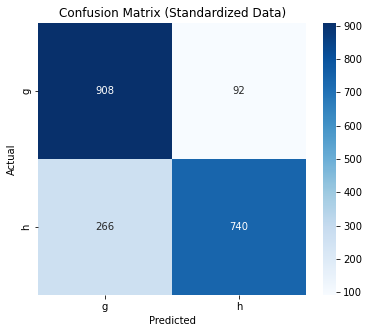

In [277]:
y_target_std = validation_set_std[class_col].to_numpy()
y_predicted_std = predictions_std

accuracy_std, metrics_df_std, conf_matrix_std = evaluate_classification(y_target_std, y_predicted_std)

print(f"Accuracy (Standardized): {accuracy_std * 100:.2f}%\n")
print("Per-class metrics (Standardized):")
print(metrics_df_std)

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_std, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df_std['Class'],
            yticklabels=metrics_df_std['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Standardized Data)")
plt.show()

In [285]:
# KNN implementation using scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Separate features and target
X = telescope_data.iloc[:, :-1]
Y = telescope_data[class_col]

# Step 1: Split into training + temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=0
)

# Step 2: Split the temp data into validation and test sets equally (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0
)

clf = KNeighborsClassifier(n_neighbors=25)
clf.fit(X_train, y_train)
print("validation set predictions: {}".format(clf.predict(X_val)))

validation set predictions: ['h' 'h' 'g' ... 'g' 'h' 'h']


In [286]:
print("validation set accuracy: {:.2f}%".format(clf.score(X_val, y_val) * 100))

validation set accuracy: 77.17%


In [287]:
# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit only on training data, then transform all
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# KNN Training
clf = KNeighborsClassifier(n_neighbors=25)
clf.fit(X_train_scaled, y_train)

,n_neighbors,25
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Validation Accuracy: 81.16%

Classification Report:
              precision    recall  f1-score   support

           g       0.76      0.90      0.82       973
           h       0.89      0.73      0.80      1033

    accuracy                           0.81      2006
   macro avg       0.82      0.81      0.81      2006
weighted avg       0.82      0.81      0.81      2006



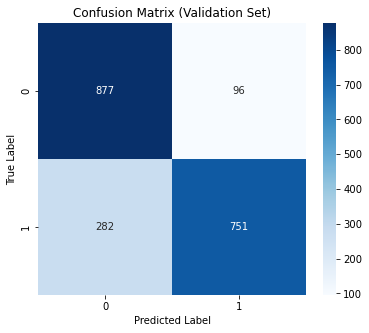

In [288]:
# classification evaluation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_val_pred = clf.predict(X_val_scaled)

# Evaluation
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()